In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 23)
(709325, 20)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
pp.get_feature_list()

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat']

In [8]:
# records of all years
use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_all_valid = pp.dataset(feature='delivered', valid=True)
df_all_valid = pp.dataset(feature_set=use_features, valid=True)
df_all_valid.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(1444435, 10)

In [9]:
# records of last year
df_last_year_valid = pp.dataset(feature_set=use_features, valid=True, date=('2016-10-01', '2017-10-01'))
df_last_year_valid.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(37638, 10)

In [10]:
df_last_year_valid.head()

,num_bath,sqft,sold_price_zip_avg,impr_over_land,sqft_zip_avg,pool,sold_price,num_bed,view,sqft_price_zip_avg
0,2.0,1332,449862.928349,0.587882,1623.522326,0,520000,3.0,0,285.766355
1,2.0,1624,449862.928349,1.195835,1623.522326,0,490000,3.0,0,285.766355
2,1.0,969,449862.928349,0.211533,1623.522326,0,410000,3.0,0,285.766355
3,3.0,2467,449862.928349,1.887844,1623.522326,0,627500,5.0,0,285.766355
5,2.0,1603,449862.928349,0.791441,1623.522326,0,445000,3.0,0,285.766355


In [11]:
X = df_last_year_valid[use_features]
y = np.ravel(df_last_year_valid['sold_price'])

### LinearRegression

In [30]:
from sklearn.linear_model import Ridge
rr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ElasticNet(random_state=42))
     ])
parameters = {'clf__l1_ratio': [0.05, 0.07, 0.1, 0.12, 0.14],
              'clf__alpha': [0.01, 0.03, 0.05, 0.07, 0.09]}
model = GridSearchCV(rr, parameters, cv=3, verbose=True, n_jobs=-1)

mm = ModelManager(df_last_year_valid, use_features, 'sold_price', model)
mm.run()

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    8.9s finished


171798.38273321016

In [31]:
mm.summary()

[dp] best params: {'clf__l1_ratio': 0.14, 'clf__alpha': 0.01}
[dp] best score: 0.7761613685828692
[dp] cv results:
{'mean_fit_time': array([ 0.11607305,  0.28925673,  0.31584009,  0.28475714,  0.27222443,
        0.15825486,  0.22392933,  0.22025132,  0.17179076,  0.19602259,
        0.12266024,  0.13335466,  0.16293367,  0.10661674,  0.15708502,
        0.12366184,  0.13251988,  0.12416442,  0.10879   ,  0.1336898 ,
        0.08673072,  0.12232653,  0.12449773,  0.12249017,  0.06600841]),
 'mean_score_time': array([ 0.00317375,  0.00334191,  0.00317605,  0.00350976,  0.00350928,
        0.00351   ,  0.00401123,  0.00334358,  0.00317526,  0.00334207,
        0.0035092 ,  0.00284211,  0.00317502,  0.00317709,  0.00317581,
        0.00351048,  0.00300837,  0.00300892,  0.00317581,  0.00300892,
        0.00300805,  0.00317574,  0.00317637,  0.00334271,  0.00200502]),
 'mean_test_score': array([ 0.77612151,  0.77613049,  0.77614383,  0.77615263,  0.77616137,
        0.77507012,  0.775108  

In [32]:
mm.plot_feature_importance()

[dp] StandardScaler->ElasticNet has no feature_importances_


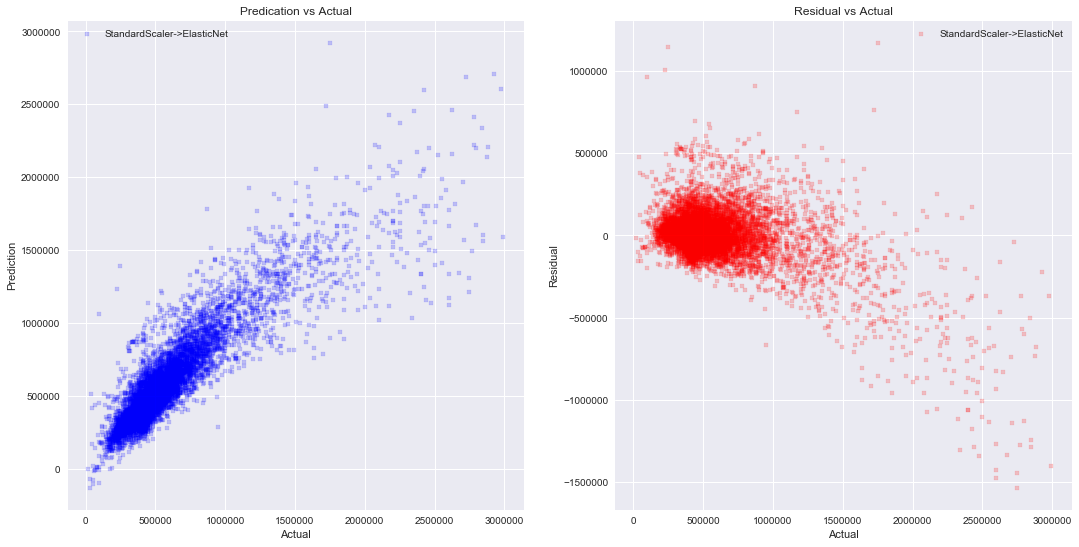

In [33]:
mm.plot_residual()

## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [34]:
ntrees = np.arange(10,200,20)
depths = np.arange(1,8)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}
rf = RandomForestRegressor(n_jobs=-1, random_state=17)
model = GridSearchCV(rf, parameters, cv=3, verbose=True, n_jobs=-1)
mm = ModelManager(df_last_year_valid, use_features, 'sold_price', model)
mm.run()

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  3.0min finished


146686.02875919602

In [35]:
mm.summary()

[dp] best params: {'n_estimators': 170, 'max_depth': 7}
[dp] best score: 0.8418818375936694
[dp] cv results:
{'mean_fit_time': array([ 0.12431812,  0.28692937,  0.40159186,  0.53849983,  0.82046652,
        0.93679031,  1.03358579,  1.14504051,  1.66601721,  1.48996298,
        0.19977164,  0.3255736 ,  0.52447526,  0.74436593,  1.06683675,
        1.2245942 ,  1.84773397,  2.0380315 ,  2.43325965,  3.00098093,
        0.13886905,  0.39622021,  0.61112499,  0.98244588,  1.29577971,
        1.67094358,  2.09958307,  2.3539265 ,  2.81481997,  3.21555217,
        0.61797635,  0.56817794,  0.93014177,  1.50934664,  2.03140314,
        2.18497745,  2.66575599,  3.32300472,  3.71053505,  3.93346079,
        0.68716089,  0.5705173 ,  1.04346577,  2.24049997,  3.09319599,
        3.2682608 ,  3.72311417,  4.03456322,  4.76149646,  4.82265973,
        1.03140918,  1.1585815 ,  1.61730099,  2.26351945,  2.91057412,
        3.65238055,  4.31514239,  5.21431128,  5.99728354,  5.77117944,
        0

[dp] training error: 134589.63200645856
[dp] testing error: 146686.02875919602


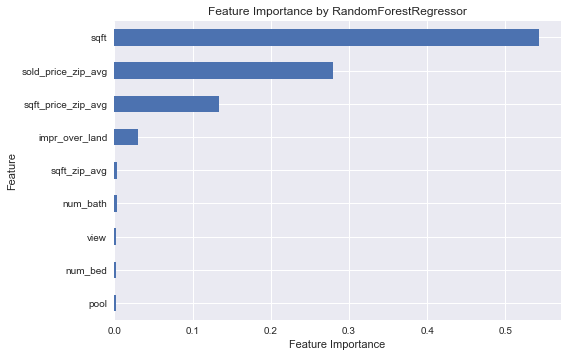

In [36]:
mm.plot_feature_importance()

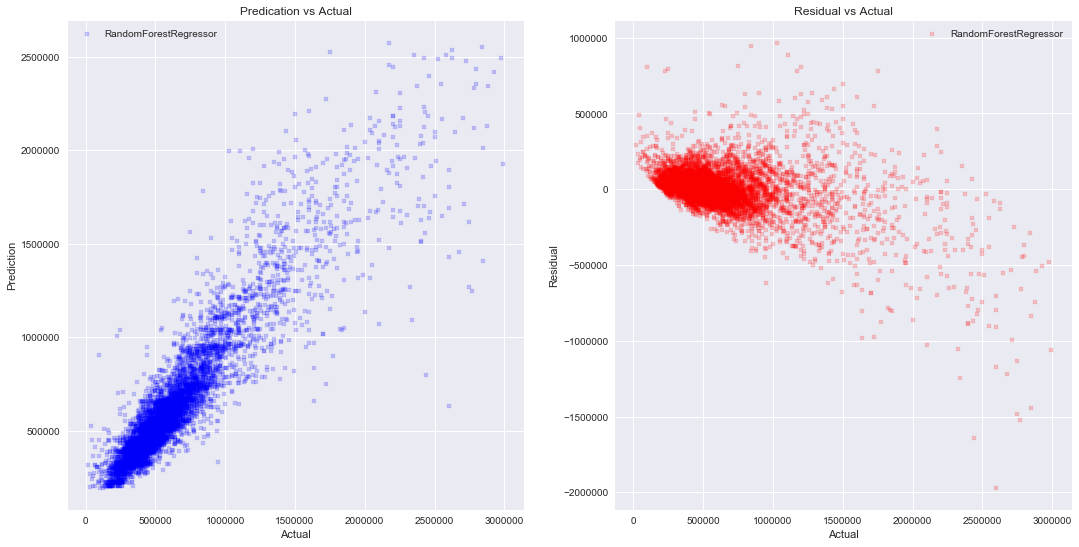

In [37]:
mm.plot_residual()